Circuit context


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/q_env_config.py:106: UserWarning: No backend was provided, State vector simulation will be used
  warnings.warn("No backend was provided, State vector simulation will be used")


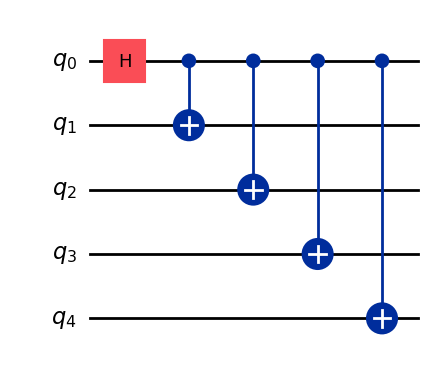

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from template_configurations.qiskit.gate_level import (
    q_env_config as gate_q_env_config,
    circuit_context,
)
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

circuit_context.draw("mpl")

In [2]:
from qiskit.visualization import plot_circuit_layout

if (
        gate_q_env_config.backend_config.backend is not None
        and circuit_context.layout is not None
):
    fig = plot_circuit_layout(
        circuit_context, gate_q_env_config.backend_config.backend, view="physical"
    )

In [3]:
use_context = False
if use_context:
    q_env = ContextAwareQuantumEnvironment(
        gate_q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(gate_q_env_config)
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/helper_functions.py:1616: UserWarning: No Backend was provided, using default values for dt, coupling_map, basis_gates and instruction_durations
  warnings.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/quantumenvironment.py:960: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]


Starting simulation benchmark...
Avg gate fidelity: 0.24224415404943958
Finished simulation benchmark
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])
Finished Estimator job
Starting simulation benchmark...
Avg gate fidelity: 0.24224415404943958
Finished simulation benchmark


In [4]:
q_env.target.input_states[0][1].target_state.dm

DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2))


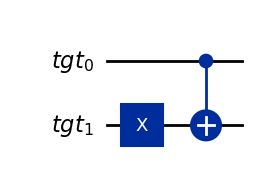

In [5]:
q_env.target.input_states[0][1].target_state.circuit.decompose().draw("mpl")

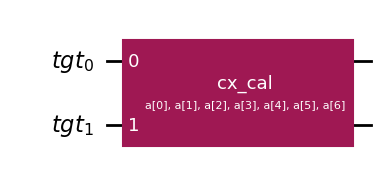

In [6]:
q_env.circuit_truncations[0].draw("mpl", style="iqp")

In [7]:
fig = None
if use_context:
    fig = q_env.circuit_context.draw("mpl")
fig

In [8]:
from qiskit.visualization import plot_gate_map

fig = None
if q_env.backend is not None and q_env.backend_info.coupling_map.size() != 0:
    fig = plot_gate_map(q_env.backend)
fig

In [9]:
from helper_functions import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd().parent.parent.parent / "template_configurations" / file_name

agent_config = load_from_yaml_file(file_location)

In [10]:
from ppo import CustomPPO

ppo_agent = CustomPPO(agent_config, rescaled_env)

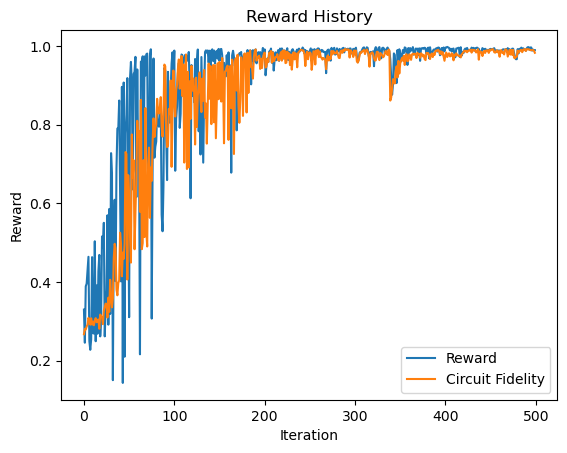

100%|██████████| 500/500 [02:15<00:00,  3.68it/s]

Average fidelity of last gate: 0.9825720124368561


In [11]:
ppo_agent.train(total_updates=500, print_debug=False, num_prints=1, clear_history=False)

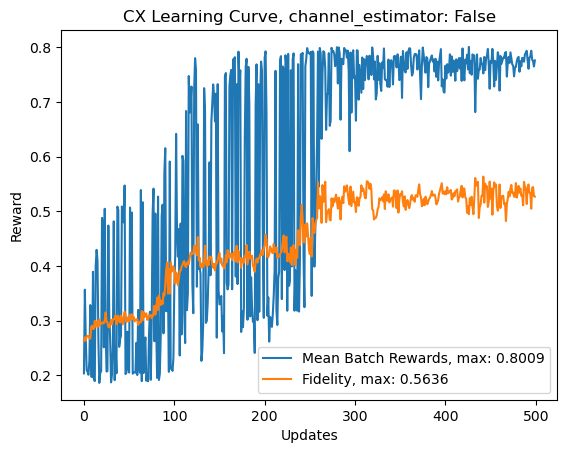

In [33]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, channel_estimator: {q_env.channel_estimator}"
)
plt.legend()
plt.show()

In [ ]:
plt.plot(np.cumsum(q_env.total_shots), label="Number of shots")
plt.xlabel("Updates")
plt.ylabel("Shots")
plt.title(f"Shots Learning Curve, channel_estimator: {q_env.channel_estimator}")
plt.legend()

In [ ]:
convergence_iteration = 60
print(
    "Number of shots required for convergence:",
    np.cumsum(q_env.total_shots[:convergence_iteration]),
)

In [ ]:
q_env.optimal_action / np.pi

In [ ]:
from torchsummary import summary

summary(ppo_agent.agent, q_env.observation_space.shape)

In [ ]:
q_env.target["input_states"][0][3]["target_state"]["circuit"].draw("mpl")

In [ ]:
q_env.target["input_states"][0][3]["target_state"]["dm"].dims()

In [ ]:
from qiskit.quantum_info import average_gate_fidelity
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CXGate
from qiskit.circuit import ParameterVector

qr = QuantumRegister(2, "q")
qc = QuantumCircuit(qr)
theta = ParameterVector("θ", 7)
q_env.parametrized_circuit_func(
    qc, theta, qr, target=q_env.target, backend=q_env.backend
)
qc.draw("mpl")

In [ ]:
qc.assign_parameters(q_env.optimal_action, inplace=True)
qc.draw("mpl")

In [ ]:
from qiskit.quantum_info import Operator

average_gate_fidelity(Operator(qc), q_env.target["gate"])